# Preprocessiong

## Import of Packages

In [1]:
import scipy.stats as stats
import heapq
from collections import defaultdict
from datetime import datetime, timedelta
import pandas as pd

import math
import folium
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


## Import Data

In [2]:

def import_data():
    gtfs_dir = '/Users/paulinaheine/Codes/BackupTravelPlanning/GTFS_OP_2024_obb-2/'

    # Load data
    agency_df = pd.read_csv(gtfs_dir + 'agency.txt')
    stops_df = pd.read_csv(gtfs_dir + 'stops.txt')
    routes_df = pd.read_csv(gtfs_dir + 'routes.txt')
    trips_df = pd.read_csv(gtfs_dir + 'trips.txt')
    stop_times_df = pd.read_csv(gtfs_dir + 'stop_times.txt')
    calendar_df = pd.read_csv(gtfs_dir + 'calendar.txt')
    calendar_dates_df = pd.read_csv(gtfs_dir + 'calendar_dates.txt')
    shapes_df = pd.read_csv(gtfs_dir + 'shapes.txt')
    
    # Return all DataFrames
    return agency_df, stops_df, routes_df, trips_df, stop_times_df, calendar_df, calendar_dates_df, shapes_df




## Helping Functions

In [3]:
'''
Functions for time conversion and service availability checks.
'''



def time_to_minutes(time_str: str) -> float:
    """
    Converts a time string from 'HH:MM:SS' format into total minutes.

    Parameters:
    - time_str (str): Time in 'HH:MM:SS' format.

    Returns:
    - (float): Total minutes.
    """
    hours, minutes, seconds = map(int, time_str.split(":"))
    return hours * 60 + minutes + seconds / 60

def minutes_to_time(minutes: float) -> str:
    """
    Converts total minutes into a time string in 'HH:MM' format.

    Parameters:
    - minutes (float): Total minutes.

    Returns:
    - (str): Time in 'HH:MM' format.
    """
    hours = int(minutes // 60)
    minutes = int(minutes % 60)
    return f"{hours:02d}:{minutes:02d}"

def get_weekday(date: datetime) -> str:
    """
    Returns the weekday name for a given date.

    Parameters:
    - date (datetime): A datetime object.

    Returns:
    - (str): Weekday name (e.g., 'monday', 'tuesday').
    """
    weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    return weekdays[date.weekday()]

def get_available_service_ids(start_date: str, calendar, calendar_dates) -> list:
    """
    Determines the available service IDs for a given date, considering regular schedules and exceptions.

    Parameters:
    - start_date (str): The date in 'YYYY-MM-DD' format.
    - calendar (DataFrame): Contains the general service schedules.
    - calendar_dates (DataFrame): Contains exceptions (added or removed services).

    Returns:
    - (list): A list of service IDs available on the given date.
    """

    # Convert start_date to YYYYMMDD format
    start_date_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    start_date_str = start_date_datetime.strftime("%Y%m%d")

    # Get the weekday name for checking in the calendar
    weekday = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"][start_date_datetime.weekday()]

    available_service_ids = []

    #Step 1: Check regular service availability from the 'calendar'
    for _, service in calendar.iterrows():
        service_id = service["service_id"]

        # Ensure the service is within the valid date range
        if int(service["start_date"]) <= int(start_date_str) <= int(service["end_date"]):
            # Check if the service runs on the given weekday
            if service[weekday] == 1:
                if service_id not in available_service_ids:
                    available_service_ids.append(service_id)

    #Step 2: Apply exceptions from 'calendar_dates'
    exceptions = calendar_dates[calendar_dates["date"] == int(start_date_str)]
    
    for _, exception in exceptions.iterrows():
        service_id = exception["service_id"]
        
        # Exception type 2: Service is added
        if exception["exception_type"] == 2:
            if service_id not in available_service_ids:
                available_service_ids.append(service_id)
        
        # Exception type 1: Service is removed
        elif exception["exception_type"] == 1:
            if service_id in available_service_ids:
                available_service_ids.remove(service_id)

    return available_service_ids 

def prepare_calendar_dates(calendar_dates) -> dict:
    """
    Groups 'calendar_dates' by service ID and converts them into a dictionary.

    Parameters:
    - calendar_dates (DataFrame): Contains exceptions for specific service dates.

    Returns:
    - (dict): Dictionary where keys are 'service_id' and values are lists of exception records.
    """
    grouped = calendar_dates.groupby("service_id")
    calendar_dates_dict = {}

    for service_id, group in grouped:
        # Convert each group into a list of dictionaries
        exceptions = group.to_dict(orient="records")
        calendar_dates_dict[service_id] = exceptions

    return calendar_dates_dict


# Graph creation

Create Graph

In [4]:

def create_graph_with_schedule(stop_times, stops, trips, calendar, calendar_dates, start_time_obj, end_time_obj):
    """
    Creates a transit graph based on available trips within a specified time window.
    
    Parameters:
    - stop_times (DataFrame): Contains stop times for all trips.
    - stops (DataFrame): Contains stop information, including stop IDs and names.
    - trips (DataFrame): Contains trip information, linking trip IDs to service IDs.
    - calendar (DataFrame): Defines the schedule of regular services.
    - calendar_dates (DataFrame): Specifies exceptions, such as added or removed services.
    - start_time_obj (datetime): The start of the considered time window.
    - end_time_obj (datetime): The end of the considered time window.

    Returns:
    - graph (dict): A dictionary where each stop name maps to a list of tuples representing 
    connections (destination stop, departure time, arrival time, route ID).
    """

    graph = defaultdict(list)  # Initializes an empty graph using a dictionary with lists as default values.

    # Create a mapping from stop IDs to stop names for better readability.
    stop_id_to_name = stops.set_index("stop_id")["stop_name"].to_dict()

    # Retrieve all valid service IDs for the specified day.
    available_services = get_available_service_ids(start_time_obj.strftime("%Y-%m-%d"), calendar, calendar_dates)
    print(len(available_services))  # Prints the number of available services for debugging purposes.

    # Sort stop times to ensure sequential processing.
    stop_times = stop_times.sort_values(by=["trip_id", "stop_sequence"])

    # Convert time strings to numerical minute values for easier comparisons.
    stop_times["arrival_minutes"] = stop_times["arrival_time"].apply(time_to_minutes)
    stop_times["departure_minutes"] = stop_times["departure_time"].apply(time_to_minutes)

    # Create a mapping from trip IDs to service IDs for quick lookup.
    trip_id_to_service = trips.set_index("trip_id")["service_id"].to_dict()
    stop_times["service_id"] = stop_times["trip_id"].map(trip_id_to_service)

    # Convert start and end times to numerical minute values.
    start_minutes = time_to_minutes(start_time_obj.strftime("%H:%M:%S"))
    end_minutes = time_to_minutes(end_time_obj.strftime("%H:%M:%S"))

    # Filter stop times to include only those that:
    # - Have arrival times after the start time.
    # - Have departure times before the end time.
    # - Belong to available services.
    stop_times_filtered = stop_times[
        (stop_times["arrival_minutes"] >= start_minutes) &
        (stop_times["departure_minutes"] <= end_minutes) &
        (stop_times["service_id"].isin(available_services))
    ]

    print(f"Rows after time window and service filter: {len(stop_times_filtered)}")  # Debugging output.

    # Create a mapping from trip IDs to route IDs.
    trip_id_to_route = trips.set_index("trip_id")["route_id"].to_dict()

    # Group the filtered stop times by trip ID to process each trip separately.
    grouped = stop_times_filtered.groupby("trip_id")

    # Iterate over each trip and construct the graph by creating edges between consecutive stops.
    for trip_id, group in grouped:
        stops_list = group["stop_id"].tolist()  # List of stop IDs in the trip.
        departures = group["departure_time"].apply(time_to_minutes).tolist()  # Departure times at each stop.
        arrivals = group["arrival_time"].apply(time_to_minutes).tolist()  # Arrival times at each stop.

        # Iterate through consecutive stops to create graph edges.
        for start, end, dep, arr in zip(stops_list[:-1], stops_list[1:], departures[:-1], arrivals[1:]):
            travel_time = arr - dep  # Compute travel time between stops.

            # Ensure that only valid travel times (greater than zero) are considered.
            if travel_time > 0:
                graph[stop_id_to_name[start]].append(
                    (stop_id_to_name[end], dep, arr, trip_id_to_route.get(trip_id))
                )

    return graph  # Returns the constructed transit graph.


# Reliability functions

## Transfer reliabiloity

In [5]:


def compute_transfer_probability_with_departure_delay(transfer_time):
    """
    Computes the probability of a successful transfer based on the available transfer time.

    Parameters:
    - transfer_time (float): The time available for the transfer in minutes.

    Returns:
    - (float): The probability of successfully making the transfer.

    Explanation:
    - The probability is modeled using a gamma cumulative distribution function (CDF).
    - The gamma distribution (shape parameter `a=2`, scale `2`) represents the uncertainty of train departures.
    - If the transfer time is very short, the probability is close to zero due to random delays.
    - As the transfer time increases, the probability of success rises quickly.
    - However, even with*very long transfer times (e.g., 10 hours), unexpected failures (train cancellations, major delays) 
      can still occur, so the maximum probability is capped at 0.95.

    Formula:
    - `stats.gamma.cdf(transfer_time, a=2, scale=2)` models the probability growth.
    - `min(0.95, ...)` ensures that the probability never exceeds **95%**, accounting for unpredictable disruptions.
    """

    return min(0.95, stats.gamma.cdf(transfer_time, a=2, scale=4))



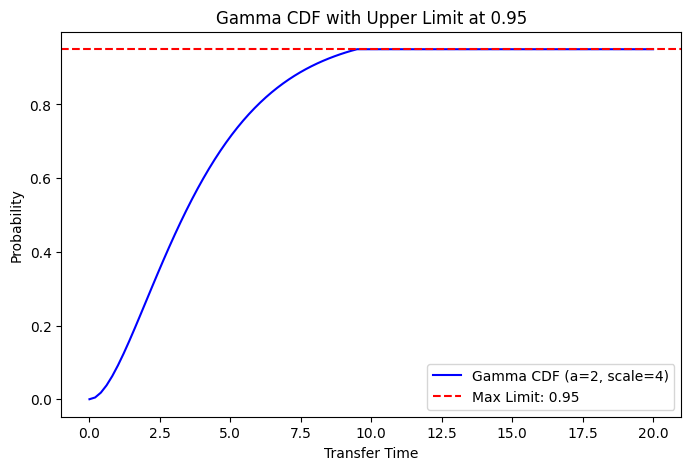

In [6]:
#change to englisch

# Werte für die x-Achse (Transferzeiten) 
transfer_times = np.linspace(0, 20, 100)

# Gamma-Kumulative Verteilungsfunktion (CDF) mit Obergrenze 0.95
gamma_cdf = np.minimum(0.95, stats.gamma.cdf(transfer_times, a=2, scale=2))

# Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(transfer_times, gamma_cdf, label="Gamma CDF (a=2, scale=4)", color="blue")

# Achsenbeschriftungen und Titel
plt.xlabel("Transfer Time")
plt.ylabel("Probability")
plt.title("Gamma CDF with Upper Limit at 0.95")
plt.axhline(y=0.95, color="red", linestyle="dashed", label="Max Limit: 0.95")
plt.legend()

# Diagramm anzeigen
plt.show()


## Total reliability

In [7]:
def compute_total_reliability(reliability_fast, backup_routes):
    """
    Computes the overall reliability of a route based on probability logic.

    Parameters:
    - reliability_fast (float): The reliability of the primary route (rel_i), ranging from 0 to 1.
    - backup_routes (list of tuples): A list of backup routes, where each backup contains its reliability.

    Returns:
    - float: The total reliability of the route (rel_{\bar{i}}), ranging from 0 to 1.

    Formula:
    - Total Reliability = Primary Route Reliability + Sum of Backup Route Reliabilities
    """

    total_reliability = reliability_fast  # Start with the primary route's reliability.

    for backup in backup_routes:
        backup_reliability = backup[2]  # Extract the reliability of the backup route.
        total_reliability += backup_reliability  # Add backup reliability to the total.

    return total_reliability  # The final reliability value is always between 0 and 1.


# Network Search 

#  A* distance calculations 

In [8]:
import math

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points on the Earth using the Haversine formula.

    Parameters:
    - lat1 (float): Latitude of the first point in decimal degrees.
    - lon1 (float): Longitude of the first point in decimal degrees.
    - lat2 (float): Latitude of the second point in decimal degrees.
    - lon2 (float): Longitude of the second point in decimal degrees.

    Returns:
    - float: The distance between the two points in kilometers.

    """

    R = 6371  # Radius of the Earth in kilometers    
    
    # Convert latitude and longitude values from degrees to radians
    phi1 = math.radians(lat1)  # Convert latitude of point 1
    phi2 = math.radians(lat2)  # Convert latitude of point 2
    delta_phi = math.radians(lat2 - lat1)  # Difference in latitude
    delta_lambda = math.radians(lon2 - lon1)  # Difference in longitude

    # Apply the Haversine formula:
    # a is the square of half the chord length between the points.
    # Uses trigonometry to account for Earth's curvature.
    a = (math.sin(delta_phi / 2) ** 2 +
         math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2)

    # c is the angular distance in radians.
    # atan2 is used for numerical stability.
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Multiply by Earth's radius to get the distance in kilometers.
    return R * c

def heuristic(current_stop, end_name, stops_df):
    """
    Changing the estimated distance to destination into a time, since this is the format that will be used in the Network search algorithm.

    Parameters:
    - current_stop (str): Name of the current stop.
    - end_name (str): Name of the destination stop.
    - stops_df (DataFrame): DataFrame containing stop information, including latitude and longitude.

    Returns:
    - float: Estimated travel time in minutes.
    """

    # Retrieve latitude and longitude for both stops
    current_stop_row = stops_df[stops_df['stop_name'] == current_stop].iloc[0]
    end_stop_row = stops_df[stops_df['stop_name'] == end_name].iloc[0]

    current_lat = current_stop_row['stop_lat']
    current_lon = current_stop_row['stop_lon']
    end_lat = end_stop_row['stop_lat']
    end_lon = end_stop_row['stop_lon']

    # Compute the straight-line distance in kilometers
    distance_km = haversine(current_lat, current_lon, end_lat, end_lon)

    # Estimate the travel time based on an average speed of 60 km/h
    average_speed = 60  # km/h
    estimated_time_minutes = (distance_km / average_speed) * 60
    
    return estimated_time_minutes


## Network Search for the primary

In [9]:
#the normal output of our files contains a path, which is the route. An example will be explained here:
'''
path_example = [
    ("Station A", 480),   # Stop at Station A at 08:00 (480 minutes)
    ("Line 1", 485, 510), # Line 1 departs at 08:05 and arrives at 08:30
    ("Station B", 510),   # Stop at Station B at 08:30
    ("Line 1", 520, 550), # Line 2 departs at 08:40 and arrives at 09:10 no transfer occured
    ("Station C", 550),   # Stop at Station C at 09:10
    ("Line 2", 560, 600), # Line 2 departs at 09:20 and arrives at 10:00, a transfer from line 1 to line 2 occured
    ("Station D", 600)    # Final destination: Station D at 10:00
]
'''

'\npath_example = [\n    ("Station A", 480),   # Stop at Station A at 08:00 (480 minutes)\n    ("Line 1", 485, 510), # Line 1 departs at 08:05 and arrives at 08:30\n    ("Station B", 510),   # Stop at Station B at 08:30\n    ("Line 1", 520, 550), # Line 2 departs at 08:40 and arrives at 09:10 no transfer occured\n    ("Station C", 550),   # Stop at Station C at 09:10\n    ("Line 2", 560, 600), # Line 2 departs at 09:20 and arrives at 10:00, a transfer from line 1 to line 2 occured\n    ("Station D", 600)    # Final destination: Station D at 10:00\n]\n'

In [12]:
import heapq

def a_star_speed(graph, start_name, end_name, start_time_minutes, 
                    exclude_routes=set(), MIN_TRANSFER_TIME=2, stops_df=None):
    """
    Implements the A* search algorithm to find a fast primary route.

    Parameters:
    - graph (dict): The transit network graph with stops as keys and edges as lists of tuples 
      (neighbor stop, departure time, arrival time, route ID).
    - start_name (str): The name of the starting stop.
    - end_name (str): The name of the destination stop.
    - start_time_minutes (int): The start time in minutes since midnight.
    - exclude_routes (set): A set of route IDs to exclude from the search (default: empty set).
    - MIN_TRANSFER_TIME (int): The minimum transfer time required between different routes (default: 2 minutes). IMPORTANT: This changes for the backup version, but here the focus is on speed, so we allow less reliable transfers.
    - stops_df (DataFrame, optional): A DataFrame containing stop information.

    Returns:
    - tuple: (arrival time, path, reliability), where:
        - arrival time (float): The time in minutes when the destination is reached.
        - path (list): The sequence of stops and routes taken.
        - reliability (float): The overall probability of successfully completing the journey.

    IMPORTANT Notes:
       line 54 ensures that the focus is on spreed (if best_result is None or current_time < best_result[0]:   )
       line 60 ensures that the algorithm stops after the first valid path was found

    """

    # Priority queue storing (estimated total cost, current time, current stop, path, reliability, last route)
    pq = [(start_time_minutes, start_time_minutes, start_name, [], 1.0, None)]  
    visited = set()
    best_result = None  
    count = 0  # Counter for tracking successful route discoveries
    
    while pq:
        # Get the node with the lowest estimated travel time
        weight, current_time, current_stop, path, reliability, last_route = heapq.heappop(pq)

        # Avoid redundant searches by storing only the last 5 stops in the path history
        path_hash = tuple(path[-5:])  

        if (current_stop, current_time, path_hash) in visited:
            continue
        visited.add((current_stop, current_time, path_hash))

        path = path + [(current_stop, current_time)]
        
        # Check if the destination has been reached
        if current_stop == end_name:
            print("possibility")
            count += 1
            
            # Update best_result if this route is faster than previous results
            if best_result is None or current_time < best_result[0]:  
                print("possibility is better than before", best_result)
                best_result = (current_time, path, reliability)  
                
        # If at least one valid path has been found, terminate the search
        if count > 0:
            print("max iteration for here")
            return best_result  

        # Expand to neighboring stops
        for neighbor, departure_time, arrival_time, route_id in graph[current_stop]:
            
            # Only consider routes that depart after the current time and are not excluded
            if departure_time >= current_time and route_id not in exclude_routes:
                
                # Check if this is a transfer (switching routes)
                is_transfer = last_route is not None and last_route != route_id
                if is_transfer:
                    transfer_time = departure_time - current_time
                    if transfer_time < MIN_TRANSFER_TIME:
                        continue  # Skip if the transfer time is too short

                # Compute transfer reliability
                if not is_transfer:
                    transfer_reliability = 1.0
                else:
                    transfer_reliability = compute_transfer_probability_with_departure_delay(transfer_time)

                # Update time and reliability
                new_current_time = arrival_time
                new_reliability = reliability * transfer_reliability

                # Compute heuristic estimate of remaining travel time
                h = heuristic(neighbor, end_name, stops_df)

                # Add the new node to the priority queue
                heapq.heappush(pq, (
                    current_time + h,  # current time + heuristic
                    new_current_time,  
                    neighbor,
                    path + [(route_id, departure_time, arrival_time)],
                    new_reliability,
                    route_id
                ))
                
    # If no route is found, return an infinite time with an empty path and zero reliability
    return best_result if best_result else (float("inf"), [], 0.0)


In [13]:


def a_star_with_reliability_fixed(graph, start_name, end_name, start_time_minutes, 
                                  exclude_routes=set(), MIN_TRANSFER_TIME=4, stops_df=None):
    """
    Implements an A* search algorithm that prioritizes route reliability while maintaining efficiency.

    Parameters:
    - graph (dict): The transit network graph, where each stop is a key mapping to a list of tuples
      (neighbor stop, departure time, arrival time, route ID).
    - start_name (str): The starting stop name.
    - end_name (str): The destination stop name.
    - start_time_minutes (int): The departure time in minutes since midnight.
    - exclude_routes (set): A set of route IDs to be ignored in the search (default: empty set).
    - MIN_TRANSFER_TIME (int): The minimum transfer time allowed in minutes (default: 4 minutes). IMPORTANT: The time is now doubled, to naturally increase the reliability 
    - stops_df (DataFrame, optional): A DataFrame containing stop information.

    Returns:
    - tuple: (arrival time, path, reliability), where:
        - arrival time (float): The time in minutes when the destination is reached.
        - path (list): The sequence of stops and routes taken.
        - reliability (float): The overall probability of successfully completing the journey.

    IMPORTANT Notes:
       line 52 ensures that the focus is on reliability ( if best_result is None or reliability > best_result[2]:  )
       line 58 ensures that the algorithm stops after the third valid path was found
    """

    # Priority queue storing (estimated total cost, current time, current stop, path, reliability, last route)
    pq = [(start_time_minutes, start_time_minutes, start_name, [], 1.0, None)]
    visited = set()
    best_result = None  
    count = 0  # Counter for tracking successful route discoveries

    while pq:
        # Get the node with the lowest estimated travel time
        weight, current_time, current_stop, path, reliability, last_route = heapq.heappop(pq)

        # Avoid redundant searches by tracking only the last 5 stops in the path
        path_hash = tuple(path[-5:])
        if (current_stop, current_time, path_hash) in visited:
            continue
        visited.add((current_stop, current_time, path_hash))

        path = path + [(current_stop, current_time)]

        # Check if the destination has been reached
        if current_stop == end_name:
            print("possibility")
            count += 1
            
            # Update best_result if this route has a higher reliability
            if best_result is None or reliability > best_result[2]:  
                print("possibility is better than before", best_result)
                best_result = (current_time, path, reliability)  
                
        # If three valid paths has been found, terminate the search
        if count > 2:
            print("max iteration for here")
            return best_result  

        # Expand to neighboring stops
        for neighbor, departure_time, arrival_time, route_id in graph[current_stop]:
            
            # Only consider routes that depart after the current time and are not excluded
            if departure_time >= current_time and route_id not in exclude_routes:
                
                # Check if this is a transfer (switching routes)
                is_transfer = last_route is not None and last_route != route_id
                if is_transfer:
                    transfer_time = departure_time - current_time
                    if transfer_time < MIN_TRANSFER_TIME or transfer_time > 60:
                        continue  # Skip if the transfer time is too short or too long

                # Compute transfer reliability
                if not is_transfer:
                    transfer_reliability = 1.0
                else:
                    transfer_reliability = compute_transfer_probability_with_departure_delay(transfer_time)

                # Update time and reliability
                new_current_time = arrival_time
                new_reliability = reliability * transfer_reliability

                # Compute heuristic estimate of remaining travel time
                h = heuristic(neighbor, end_name, stops_df)

                # Add the new node to the priority queue
                heapq.heappush(pq, (
                    new_current_time + h,  # Estimated total travel time (current time + heuristic)
                    new_current_time,
                    neighbor,
                    path + [(route_id, departure_time, arrival_time)],
                    new_reliability,
                    route_id
                ))

    # If no route is found, return an infinite time with an empty path and zero reliability
    return best_result if best_result else (float("inf"), [], 0.0)


# Backup Seach Algorithm

In [27]:
def a_star_backups(graph, path_fixed):
    """
    Finds and evaluates backup routes at transfer points along a fixed primary path.

    Parameters:
    - graph (dict): The transit network graph, where each stop is a key mapping to a list of tuples
      (neighbor stop, departure time, arrival time, route ID).
    - path_fixed (list): The primary route, represented as a sequence of stops and their respective times.

    Returns:
    - backup_routes (list): A list of backup routes, where each backup contains:
        - backup_time (float): Estimated arrival time of the backup route.
        - backup_path (list): The sequence of stops in the backup route.
        - backup_reliability (float): The probability of successfully completing the backup route.

    """

    backup_routes = []
    last_route = None
    rel_before_trans = 1  # Reliability of the path before a transfer occurs

    # Iterate over all transfer points (odd indices in path_fixed)
    for i in range(1, len(path_fixed) - 1, 2):
        transfer_stop, current = path_fixed[i - 1]  # Stop where transfer occurs
        route_id, departure_time, arrival_time = path_fixed[i]  # Current trip details
        next_stop, _ = path_fixed[i + 1]  # Next stop in the route

        transfer_time_inbetween = departure_time - current  # Time available for transfer

        # If switching to a new route, compute transfer reliability and check for backup options
        if route_id != last_route:
            print(f"Checking backup options from {transfer_stop}")

            # Compute probability of successfully making the transfer
            rel_transfer = compute_transfer_probability_with_departure_delay(transfer_time_inbetween)
            rel_before_trans = rel_before_trans * rel_transfer
            
            # Compute probability of missing the transfer
            missed_trans_rel = 1 - compute_transfer_probability_with_departure_delay(transfer_time_inbetween)

            # Find a backup route in case the transfer is missed
            backup_time, backup_path, backup_reliability = a_star_with_reliability_fixed(
                graph, 
                transfer_stop, 
                path_fixed[-1][0], 
                start_time_minutes=departure_time + 1, # we start one minute after the departure of the inital train to simulate that we missed it
                stops_df=stops, 
                MIN_TRANSFER_TIME=4, 
                exclude_routes=set()
            )

            # Compute the overall backup reliability considering missed transfer probability
            total_backup_reliability = missed_trans_rel * backup_reliability * rel_before_trans
            
            # Store the backup route details
            backup_routes.append([backup_time, backup_path, total_backup_reliability])

        last_route = route_id  # Update last route ID

    return backup_routes


# Main

In [28]:
agency, stops, routes, trips, stop_times, calendar, calendar_dates, shapes = import_data()
start_stop_name =  "Schattendorf Kirchengasse"
end_stop_name = "Flughafen Wien Bahnhof"
start_datetime = "2024-12-12 14:30:00"
time_budget = "2:30"
time_budget_hours, time_budget_minutes = map(int, time_budget.split(":"))
time_budget_minutes = time_budget_hours * 60 + time_budget_minutes / 60

start_time_obj = datetime.strptime(start_datetime, "%Y-%m-%d %H:%M:%S")
start_time_minutes = start_time_obj.hour * 60 + start_time_obj.minute

# In ein reines date-Objekt umwandeln
start_time_obj = datetime.strptime(start_datetime, "%Y-%m-%d %H:%M:%S")
end_time_obj = start_time_obj + timedelta(minutes=time_budget_minutes)
date_obj = start_time_obj.date()

start_time_minutes = start_time_obj.hour * 60 + start_time_obj.minute
    
print("creating graph")
graph = create_graph_with_schedule(stop_times, stops, trips, calendar, calendar_dates, start_time_obj, end_time_obj)


current_time_fast, best_result_fast , reliability_fast = a_star_speed(graph, start_stop_name, end_stop_name, start_time_minutes,  exclude_routes=set(), MIN_TRANSFER_TIME=2,stops_df=stops)

# Backup-Routen berechnen
print("backups")
backup_routes = a_star_backups(graph,best_result_fast)

total_reliability =compute_total_reliability(reliability_fast, backup_routes)

creating graph
1907
Rows after time window and service filter: 20376
possibility
possibility is better than before None
max iteration for here
backups
Checking backup options from Schattendorf Kirchengasse
Checking backup options from Loipersbach-Schattendorf Bhf.
Checking backup options from Wiener Neustadt Hauptbahnhof
possibility
possibility is better than before None
possibility
possibility
max iteration for here
Checking backup options from Wien Hauptbahnhof
possibility
possibility is better than before None
possibility


## Display the result

In [36]:
def format_travel_path(path):
    formatted_output = []
    
    for entry in path:
        if len(entry) == 2:
            formatted_output.append(f"Stop: {entry[0]} at {format_time(entry[1])}")
        elif len(entry) == 3:
            formatted_output.append(f"Line: {entry[0]} | Departure: {format_time(entry[1])} | Arrival: {format_time(entry[2])}")
    
    return "\n".join(formatted_output)

def format_time(minutes):
    minutes = int(minutes)  # Ensure minutes is an integer
    hours = minutes // 60
    mins = minutes % 60
    return f"{hours:02d}:{mins:02d}"

In [37]:
format_travel_path(best_result_fast)

'Stop: Schattendorf Kirchengasse at 14:30\nLine: 20-SV5-L-j24-1 | Departure: 14:43 | Arrival: 14:48\nStop: Loipersbach-Schattendorf Bhf. at 14:48\nLine: 3-R93-A-j24-1 | Departure: 14:54 | Arrival: 14:58\nStop: Marz-Rohrbach Bahnhof at 14:58\nLine: 3-R93-A-j24-1 | Departure: 14:59 | Arrival: 15:01\nStop: Mattersburg Bahnhof at 15:01\nLine: 3-R93-A-j24-1 | Departure: 15:02 | Arrival: 15:03\nStop: Mattersburg Nord Bahnhof at 15:03\nLine: 3-R93-A-j24-1 | Departure: 15:04 | Arrival: 15:07\nStop: Wiesen-Sigleß Bahnhof at 15:07\nLine: 3-R93-A-j24-1 | Departure: 15:07 | Arrival: 15:11\nStop: Bad Sauerbrunn Bahnhof at 15:11\nLine: 3-R93-A-j24-1 | Departure: 15:13 | Arrival: 15:16\nStop: Neudörfl Bahnhof at 15:16\nLine: 3-R93-A-j24-1 | Departure: 15:17 | Arrival: 15:20\nStop: Katzelsdorf Bahnhof at 15:20\nLine: 3-R93-A-j24-1 | Departure: 15:20 | Arrival: 15:25\nStop: Wiener Neustadt Hauptbahnhof at 15:25\nLine: 10-A12-j24-1 | Departure: 15:27 | Arrival: 15:55\nStop: Wien Meidling at 15:55\nLine:

# UI Prototype

In [315]:


def plot_route_on_map(primary_route, backup_routes, stops_df):
    """
    Erstellt eine interaktive Karte mit der Primärroute und Backup-Routen.
    
    :param primary_route: Beste gefundene Route [(stop_name, time), (route_id, dep_time, arr_time), ...]
    :param backup_routes: Liste von Backup-Routen [[arrival_time, route_list, reliability], ...]
    :param stops_df: DataFrame mit Spalten ["stop_name", "stop_lat", "stop_lon"]
    :return: Eine interaktive Folium-Karte
    """
    
    # Startpunkt finden (erste Haltestelle in der Primärroute)
    first_stop = next((stop for stop in primary_route if isinstance(stop, tuple) and len(stop) == 2), None)
    
    if not first_stop:
        print("Keine gültigen Haltestellen gefunden.")
        return None
    
    first_stop_name = first_stop[0]
    
    # Koordinaten des Startpunkts holen
    start_coords = stops_df.loc[stops_df["stop_name"] == first_stop_name, ["stop_lat", "stop_lon"]].values
    if len(start_coords) == 0:
        print("Startpunkt nicht gefunden.")
        return None
    
    start_lat, start_lon = start_coords[0]
    
    # Karte erstellen
    route_map = folium.Map(location=[start_lat, start_lon], zoom_start=10)
    
    # Haltestellen speichern
    route_coords = []
    prev_route_id = None  # Speichert die vorherige Linien-ID für Umstiegserkennung
    prev_arrival_time = None  # Speichert die vorherige Ankunftszeit für Umstiegszeit-Berechnung
    first_marker_set = False  # Damit der Einstiegspunkt markiert wird
    
    for i, entry in enumerate(primary_route):
        if isinstance(entry, tuple) and len(entry) == 2:  # Haltestelle
            stop_name, arrival_time = entry  # Name + Ankunftszeit
            stop_coords = stops_df.loc[stops_df["stop_name"] == stop_name, ["stop_lat", "stop_lon"]].values
            if len(stop_coords) > 0:
                lat, lon = stop_coords[0]
                route_coords.append((lat, lon))
                
                # Beim ersten Halt wird der Einstieg markiert
                if not first_marker_set and i+1 < len(primary_route) and isinstance(primary_route[i+1], tuple) and len(primary_route[i+1]) == 3:
                    next_route_id, dep_time, _ = primary_route[i+1]  # Nächste Linie
                    folium.Marker(
                        location=[lat, lon], 
                        popup=f"Um {int(dep_time // 60):02}:{int(dep_time % 60):02} Uhr in Linie {next_route_id} einsteigen",
                        icon=folium.Icon(color="green", icon="info-sign")
                    ).add_to(route_map)
                    first_marker_set = True  # Verhindert weitere erste Markierungen
                
                # Linienwechsel prüfen und Umstiegsmarker setzen
                if i > 1 and isinstance(primary_route[i-1], tuple) and len(primary_route[i-1]) == 3: 
                    prev_route_id = primary_route[i-1][0]  # Speichert die letzte Linien-ID
                    prev_arrival_time = primary_route[i-1][2]  # Speichert die letzte Ankunftszeit
                
                if prev_route_id and i+1 < len(primary_route) and isinstance(primary_route[i+1], tuple) and len(primary_route[i+1]) == 3:
                    current_route_id, dep_time, _ = primary_route[i+1]  # Nächste Linien-ID + Abfahrtszeit

                    # Falls sich die Linie geändert hat, setze einen Umstiegsmarker
                    if prev_route_id != current_route_id:
                        umstiegszeit = dep_time - prev_arrival_time  # Berechnung der Umstiegszeit
                        popup_text = f"Um {int(arrival_time // 60):02}:{int(arrival_time % 60):02} Uhr an {stop_name} in Linie {current_route_id} umsteigen\n" \
                                     f"➡️ Umstiegszeit: {umstiegszeit} Minuten"

                        # 🔹 Backup-Routen prüfen
                        backup_info = []
                        for backup in backup_routes:
                            backup_path = backup[1]  # Backup-Route
                            if any(stop_name == stop[0] for stop in backup_path):  # Prüfe, ob Backup hier beginnt
                                backup_route_id = backup_path[1][0]  # Erste Linie der Backup-Route
                                backup_time = backup_path[1][1]  # Erste Abfahrtszeit
                                backup_info.append(f"Backup: Um {int(backup_time // 60):02}:{int(backup_time % 60):02} in Linie {backup_route_id} einsteigen")
                        
                        # Falls Backup existiert, zur Pop-up-Beschriftung hinzufügen
                        if backup_info:
                            popup_text += "\n" + "\n".join(backup_info)

                        folium.Marker(
                            location=[lat, lon], 
                            popup=popup_text,
                            icon=folium.Icon(color="blue", icon="info-sign")
                        ).add_to(route_map)
                        prev_route_id = current_route_id  # Update die aktuelle Linie
                        prev_arrival_time = arrival_time  # Update die letzte Ankunftszeit
    
    # Primärroute auf Karte zeichnen (Blau)
    folium.PolyLine(route_coords, color="blue", weight=5, opacity=0.7, tooltip="Primärroute").add_to(route_map)

    # 🔹 Backup-Routen (Rot) einzeichnen
    for backup in backup_routes:
        backup_path = backup[1]  # Die Backup-Route selbst
        backup_coords = []
        backup_arrival_times = []

        for entry in backup_path:
            if isinstance(entry, tuple) and len(entry) == 2:  # Haltestelle
                stop_name, arrival_time = entry
                stop_coords = stops_df.loc[stops_df["stop_name"] == stop_name, ["stop_lat", "stop_lon"]].values
                if len(stop_coords) > 0:
                    lat, lon = stop_coords[0]
                    backup_coords.append((lat, lon))
                    backup_arrival_times.append(arrival_time)

        if len(backup_coords) > 1:
            folium.PolyLine(backup_coords, color="red", weight=4, opacity=0.7, tooltip="Backup-Route").add_to(route_map)

    # **🔹 Endhaltestellen-Marker hinzufügen**
    if primary_route:
        final_stop_name, final_arrival_time = primary_route[-1]
        final_coords = stops_df.loc[stops_df["stop_name"] == final_stop_name, ["stop_lat", "stop_lon"]].values
        if len(final_coords) > 0:
            lat, lon = final_coords[0]
            
            # **Backup-Ankunftszeiten sammeln**
            backup_arrivals = [
                f"Backup von {path[0][0]} um {int(path[1][1] // 60):02}:{int(path[1][1] % 60):02} Uhr – Ankunft um {int(path[-1][1] // 60):02}:{int(path[-1][1] % 60):02} Uhr"
                for _, path, _ in backup_routes if path
            ]
            backup_info = "\n".join(backup_arrivals) if backup_arrivals else "Keine Backups verfügbar"
            
            folium.Marker(
                location=[lat, lon], 
                popup=f"Ankunft Primärroute um {int(final_arrival_time // 60):02}:{int(final_arrival_time % 60):02} Uhr\n{backup_info}",
                icon=folium.Icon(color="red", icon="flag")
            ).add_to(route_map)
    
    return route_map


In [320]:
plot_route_on_map(best_result_fast,backup_routes,stops)

In [46]:
#map=plot_route_on_map(best_result_fast,backup_routes,stops)

In [321]:
route_map = plot_route_on_map(best_result_fast,backup_routes,stops)
route_map.save("route_map_enns.html")  # Falls du es als HTML speichern willst

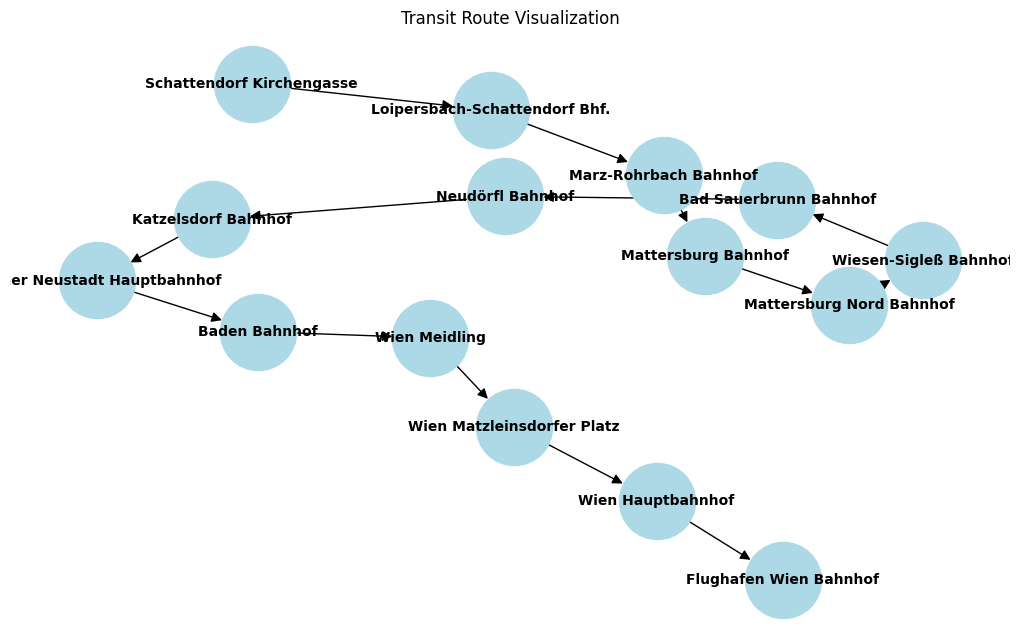

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_relevant_subgraph(graph, start_stop, end_stop):
    """
    Extracts the relevant subgraph between a start and end stop using Dijkstra.
    
    Parameters:
    - graph (dict): The full transit graph.
    - start_stop (str): The starting stop name.
    - end_stop (str): The destination stop name.

    Returns:
    - subgraph (dict): A subgraph containing only relevant stops and connections.
    """

    # Erstellt einen gerichteten Graphen
    G = nx.DiGraph()
    for stop, connections in graph.items():
        for destination, dep_time, arr_time, route_id in connections:
            travel_time = arr_time - dep_time
            if travel_time > 0:
                G.add_edge(stop, destination, weight=travel_time)

    # Prüfen, ob Start- und Endpunkt existieren
    if start_stop not in G or end_stop not in G:
        print(f"❌ {start_stop} oder {end_stop} existiert nicht im Graphen!")
        return {}

    # Kürzesten Pfad mit Dijkstra suchen
    try:
        shortest_path = nx.shortest_path(G, source=start_stop, target=end_stop, weight="weight")
    except nx.NetworkXNoPath:
        print(f"❌ Kein Pfad zwischen {start_stop} und {end_stop} gefunden!")
        return {}

    # Subgraph mit nur den relevanten Haltestellen
    subgraph = defaultdict(list)
    for i in range(len(shortest_path) - 1):
        stop, next_stop = shortest_path[i], shortest_path[i + 1]

        for destination, dep_time, arr_time, route_id in graph.get(stop, []):
            if destination == next_stop:
                subgraph[stop].append((destination, dep_time, arr_time, route_id))
                break  

    return subgraph

def visualize_subgraph(graph):
    """
    Visualizes a transit subgraph using NetworkX (without edge labels).
    
    Parameters:
    - graph (dict): A dictionary where each stop name maps to connections.
    """

    G = nx.DiGraph()

    # Knoten und Kanten hinzufügen
    for stop, connections in graph.items():
        for destination, dep_time, arr_time, route_id in connections:
            G.add_edge(stop, destination)

    # Graph-Layout und Darstellung
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="black", font_size=10, font_weight="bold", arrowsize=15)

    plt.title("Transit Route Visualization")
    plt.show()

# Start und Ziel definieren
start_stop_name = "Schattendorf Kirchengasse"
end_stop_name = "Flughafen Wien Bahnhof"

# Relevanten Subgraph extrahieren
subgraph = extract_relevant_subgraph(graph, start_stop_name, end_stop_name)

# Falls ein Pfad existiert, visualisieren
if subgraph:
    visualize_subgraph(subgraph)


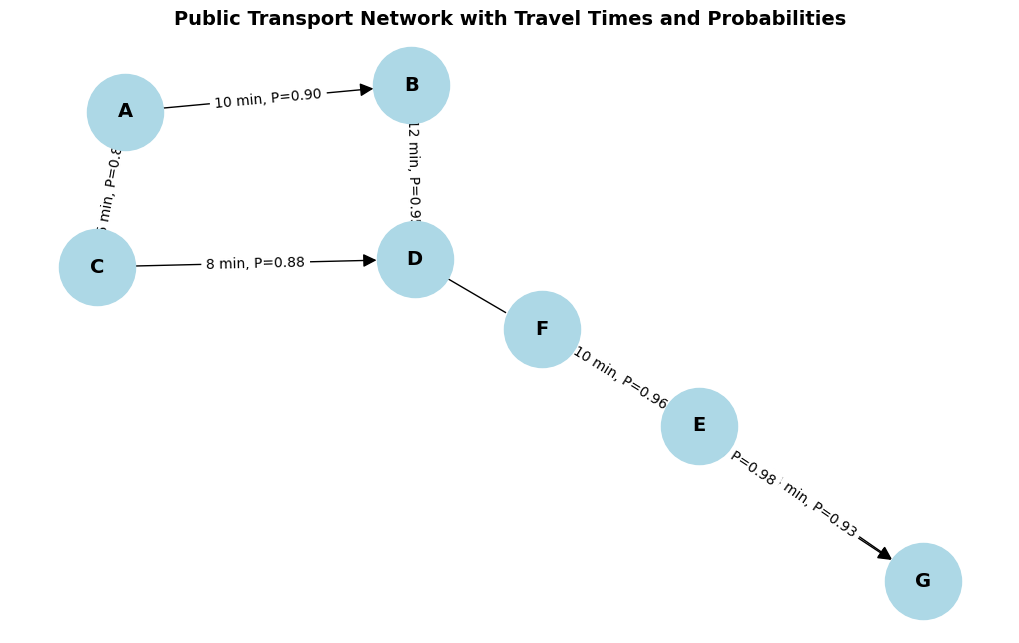

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Erstelle einen gerichteten Graphen für das Transportnetzwerk
G = nx.DiGraph()

# Definiere Knoten (Haltestellen)
stops = ["A", "B", "C", "D", "E", "F", "G"]

# Definiere Kanten mit Reisezeiten, Verzögerungen und Wahrscheinlichkeiten
edges = [
    ("A", "B", {"scheduled_time": 10, "delay_variance": 3, "probability": 0.9, "departure_times": [8, 9, 10, 14, 18]}),
    ("A", "C", {"scheduled_time": 15, "delay_variance": 5, "probability": 0.85, "departure_times": [7, 11, 15, 19]}),
    ("B", "D", {"scheduled_time": 12, "delay_variance": 4, "probability": 0.95, "departure_times": [9, 13, 17]}),
    ("C", "D", {"scheduled_time": 8, "delay_variance": 2, "probability": 0.88, "departure_times": [8, 12, 16, 20]}),
    ("D", "E", {"scheduled_time": 20, "delay_variance": 6, "probability": 0.92, "departure_times": [6, 10, 14, 18]}),
    ("E", "F", {"scheduled_time": 10, "delay_variance": 3, "probability": 0.96, "departure_times": [7, 11, 15, 19]}),
    ("E", "G", {"scheduled_time": 14, "delay_variance": 4, "probability": 0.93, "departure_times": [6, 9, 12, 15, 18]}),
    ("F", "G", {"scheduled_time": 6, "delay_variance": 2, "probability": 0.98, "departure_times": [8, 12, 16, 20]}),
]

# Knoten hinzufügen
G.add_nodes_from(stops)

# Kanten mit Attributen hinzufügen
for u, v, data in edges:
    G.add_edge(u, v, **data)

# Zufällige Verzögerung simulieren
def get_actual_travel_time(edge_data):
    return edge_data["scheduled_time"] + random.uniform(0, edge_data["delay_variance"])

# Graph visualisieren
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue",
        edge_color="black", font_size=14, font_weight="bold", arrows=True, arrowsize=20)

# Reisezeiten als Labels anzeigen
edge_labels = {(u, v): f"{data['scheduled_time']} min, P={data['probability']:.2f}" for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Public Transport Network with Travel Times and Probabilities", fontsize=14, fontweight="bold")
plt.show()
